## Importing Libraries

In [60]:
import praw
import time
import pandas as pd
import json
import re
import nltk
import ast
import random
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
import gensim
from gensim import corpora
from gensim.models import LdaModel
from nrclex import NRCLex
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain  # Louvain community detection

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
def redditClient():
    return praw.Reddit(
        client_id="Ycq3H4VRiBcOIKUlPYJ9dw",
        client_secret="IYtHpUOz3pi1_VTKhfpvLhfVK3QSNg",
        username="Aparna-2002",
        password="Appu2002",  # Make sure this is correct
        user_agent="van-gogh-project-v2"
)

reddit = redditClient()

In [3]:
# Step 2: Subreddits and Keywords (Refined)
subreddits = [
    'Art', 'ArtHistory', 'painting', 'TrueArt', 'museum',
    'AskReddit', 'philosophy', 'mentalhealth'
]

keywords = [
    "van gogh", "vincent van gogh", "vangogh",
    "van gogh mental health", "van gogh and mental illness",
    "tortured artist", "van gogh suicide", "van gogh depression",
    "sunflowers van gogh", "starry night", "cafe terrace at night",
    "van gogh museum", "post impressionism", "van gogh influence",
    "art inspired by van gogh", "why van gogh matters"
]

POSTS_PER_QUERY = 50
all_data = []
found_hashtags = set()
hashtag_pattern = re.compile(r"#\w+")
total_comments = 0
total_replies = 0


## Data Extraction

In [4]:
#  Step 3: Data Collection Loop
for subreddit_name in subreddits:
    for keyword in keywords:
        print(f"Searching '{keyword}' in r/{subreddit_name}")
        try:
            subreddit = reddit.subreddit(subreddit_name)
            for submission in subreddit.search(keyword, limit=POSTS_PER_QUERY):
                post_text = (submission.title + " " + submission.selftext).lower()
                if not any(term in post_text for term in ["van gogh", "vincent van gogh", "vangogh", "starry night"]):
                    continue  # Skip irrelevant matches

                submission.comments.replace_more(limit=None)
                for comment in submission.comments:
                    if not comment.body:
                        continue

                    comment_hashtags = hashtag_pattern.findall(comment.body)
                    found_hashtags.update(comment_hashtags)

                    data_entry = {
                        "source": "reddit",
                        "subreddit": subreddit_name,
                        "platform_id": submission.id,
                        "post_title": submission.title,
                        "post_text": submission.selftext,
                        "post_url": submission.url,
                        "post_timestamp": datetime.utcfromtimestamp(submission.created_utc).isoformat(),
                        "comment_id": comment.id,
                        "parent_id": comment.parent_id,
                        "timestamp": datetime.utcfromtimestamp(comment.created_utc).isoformat(),
                        "depth": comment.depth,
                        "author": str(comment.author) if comment.author else "deleted",
                        "text": comment.body,
                        "score": comment.score,
                        "hashtags": comment_hashtags,
                        "replies": []
                    }

                    total_comments += 1

                    # Process Replies
                    if hasattr(comment, "replies"):
                        for reply in comment.replies:
                            if not reply.body:
                                continue
                            reply_hashtags = hashtag_pattern.findall(reply.body)
                            found_hashtags.update(reply_hashtags)

                            reply_entry = {
                                "reply_id": reply.id,
                                "parent_id": reply.parent_id,
                                "author": str(reply.author) if reply.author else "deleted",
                                "timestamp": datetime.utcfromtimestamp(reply.created_utc).isoformat(),
                                "depth": reply.depth,
                                "text": reply.body,
                                "score": reply.score,
                                "hashtags": reply_hashtags
                            }
                            data_entry["replies"].append(reply_entry)
                            total_replies += 1

                    all_data.append(data_entry)
                time.sleep(1)

        except Exception as e:
            print(f"Error in r/{subreddit_name} for '{keyword}': {e}")


Searching 'van gogh' in r/Art
Searching 'vincent van gogh' in r/Art
Searching 'vangogh' in r/Art
Searching 'van gogh mental health' in r/Art
Searching 'van gogh and mental illness' in r/Art
Searching 'tortured artist' in r/Art
Searching 'van gogh suicide' in r/Art
Searching 'van gogh depression' in r/Art
Searching 'sunflowers van gogh' in r/Art
Searching 'starry night' in r/Art
Searching 'cafe terrace at night' in r/Art
Searching 'van gogh museum' in r/Art
Searching 'post impressionism' in r/Art
Searching 'van gogh influence' in r/Art
Searching 'art inspired by van gogh' in r/Art
Searching 'why van gogh matters' in r/Art
Searching 'van gogh' in r/ArtHistory
Searching 'vincent van gogh' in r/ArtHistory
Searching 'vangogh' in r/ArtHistory
Searching 'van gogh mental health' in r/ArtHistory
Searching 'van gogh and mental illness' in r/ArtHistory
Searching 'tortured artist' in r/ArtHistory
Searching 'van gogh suicide' in r/ArtHistory
Searching 'van gogh depression' in r/ArtHistory
Searching

In [5]:
# Step 4: Save Data
with open("reddit_vangogh_final3.json", "w", encoding="utf-8") as f:
    json.dump(all_data, f, ensure_ascii=False, indent=2)

with open("reddit_vangogh_hashtags_final3.json", "w", encoding="utf-8") as f:
    json.dump(sorted(list(found_hashtags)), f, ensure_ascii=False, indent=2)

print(f"Data saved successfully! Total comments: {total_comments}, replies: {total_replies}")
print("Files: reddit_vangogh_final3.json and reddit_vangogh_hashtags_final3.json")

Data saved successfully! Total comments: 23771, replies: 12021
Files: reddit_vangogh_final3.json and reddit_vangogh_hashtags_final3.json


In [6]:
# Step 5: Print Summary
print("\nData collection complete.")
print(f"Total entries collected: {len(all_data)}")
print(f"Total top-level comments: {total_comments}")
print(f"Total replies collected: {total_replies}")
print(f"Unique hashtags found: {len(found_hashtags)}")



Data collection complete.
Total entries collected: 23771
Total top-level comments: 23771
Total replies collected: 12021
Unique hashtags found: 33


In [7]:
# Load the saved JSON file
with open("reddit_vangogh_final3.json", "r", encoding="utf-8") as f:
    all_data = json.load(f)

# Convert it into a DataFrame
df = pd.DataFrame(all_data)

# Display the first 5 rows
print(df.head())


   source subreddit platform_id  \
0  reddit       Art      674ffr   
1  reddit       Art      674ffr   
2  reddit       Art      674ffr   
3  reddit       Art      674ffr   
4  reddit       Art      674ffr   

                                          post_title  \
0  Why is Van Gogh so famous when his art looks a...   
1  Why is Van Gogh so famous when his art looks a...   
2  Why is Van Gogh so famous when his art looks a...   
3  Why is Van Gogh so famous when his art looks a...   
4  Why is Van Gogh so famous when his art looks a...   

                                           post_text  \
0  I posted this in AskReddit before, but it was ...   
1  I posted this in AskReddit before, but it was ...   
2  I posted this in AskReddit before, but it was ...   
3  I posted this in AskReddit before, but it was ...   
4  I posted this in AskReddit before, but it was ...   

                                            post_url       post_timestamp  \
0  https://www.reddit.com/r/Art/commen

In [8]:
df.isnull().sum()

source            0
subreddit         0
platform_id       0
post_title        0
post_text         0
post_url          0
post_timestamp    0
comment_id        0
parent_id         0
timestamp         0
depth             0
author            0
text              0
score             0
hashtags          0
replies           0
dtype: int64

In [9]:
# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

## Exploratory Analysis - Raw Data 

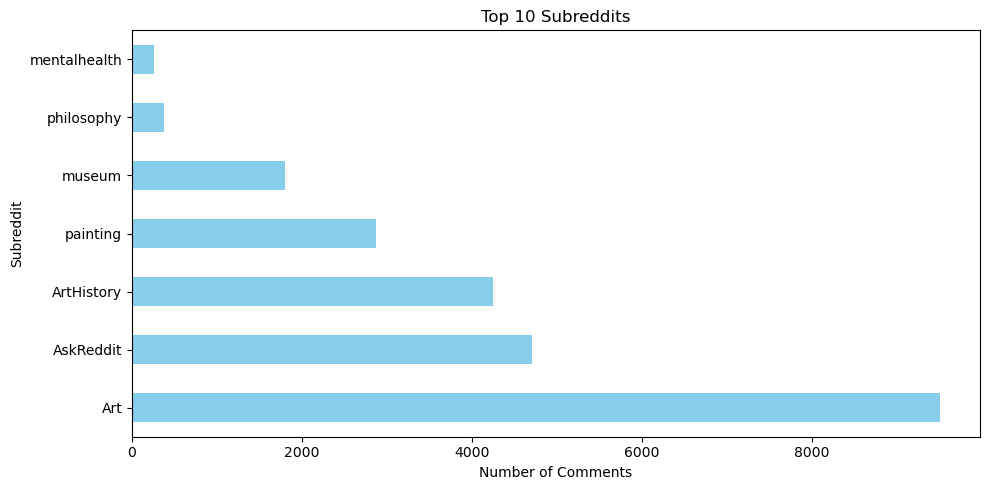

In [10]:
# 1. Subreddit distribution
plt.figure(figsize=(10, 5))
df['subreddit'].value_counts().head(10).plot(kind='barh', color='skyblue')
plt.title("Top 10 Subreddits")
plt.xlabel("Number of Comments")
plt.ylabel("Subreddit")
plt.tight_layout()
plt.show()

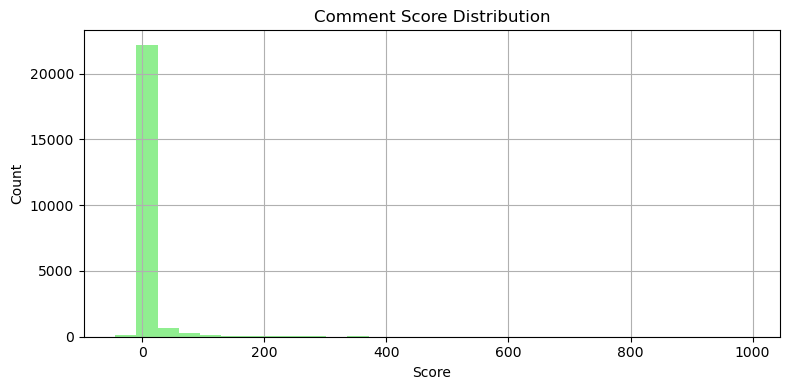

In [11]:
# 2. Comment score distribution
plt.figure(figsize=(8, 4))
df['score'].dropna().hist(bins=30, color='lightgreen')
plt.title("Comment Score Distribution")
plt.xlabel("Score")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

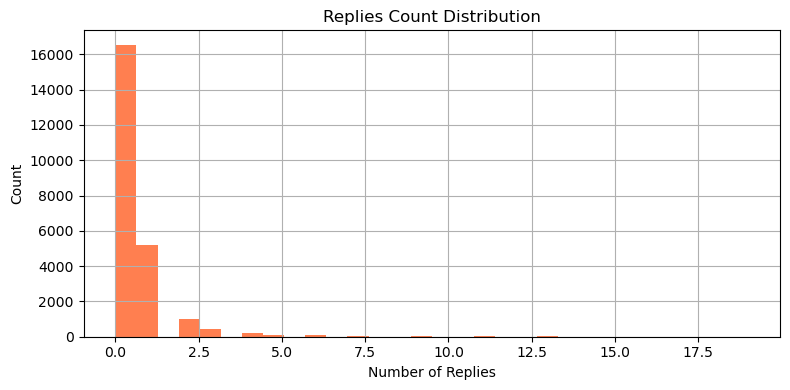

In [12]:
# 3. Replies count distribution
df['replies_count'] = df['replies'].apply(lambda x: len(x) if isinstance(x, list) else 0)
plt.figure(figsize=(8, 4))
df['replies_count'].hist(bins=30, color='coral')
plt.title("Replies Count Distribution")
plt.xlabel("Number of Replies")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

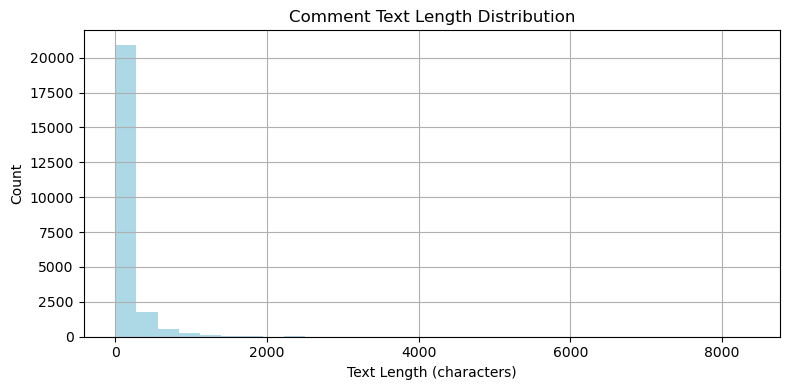

In [13]:
# 4. Comment length distribution
df['text_length'] = df['text'].apply(lambda x: len(str(x)))
plt.figure(figsize=(8, 4))
df['text_length'].hist(bins=30, color='lightblue')
plt.title("Comment Text Length Distribution")
plt.xlabel("Text Length (characters)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

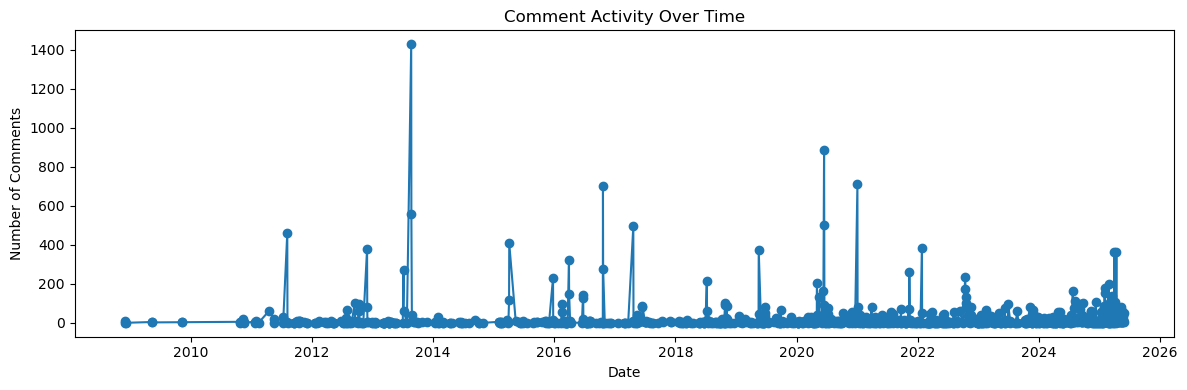

In [14]:
# 5. Activity over time (by date)
plt.figure(figsize=(12, 4))
df['timestamp'].dt.date.value_counts().sort_index().plot(kind='line', marker='o')
plt.title("Comment Activity Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Comments")
plt.tight_layout()
plt.show()

In [15]:
# Group by Year-Month (e.g., 2014-03)
df['month'] = df['timestamp'].dt.to_period('M')
monthly_counts = df['month'].value_counts().sort_index()

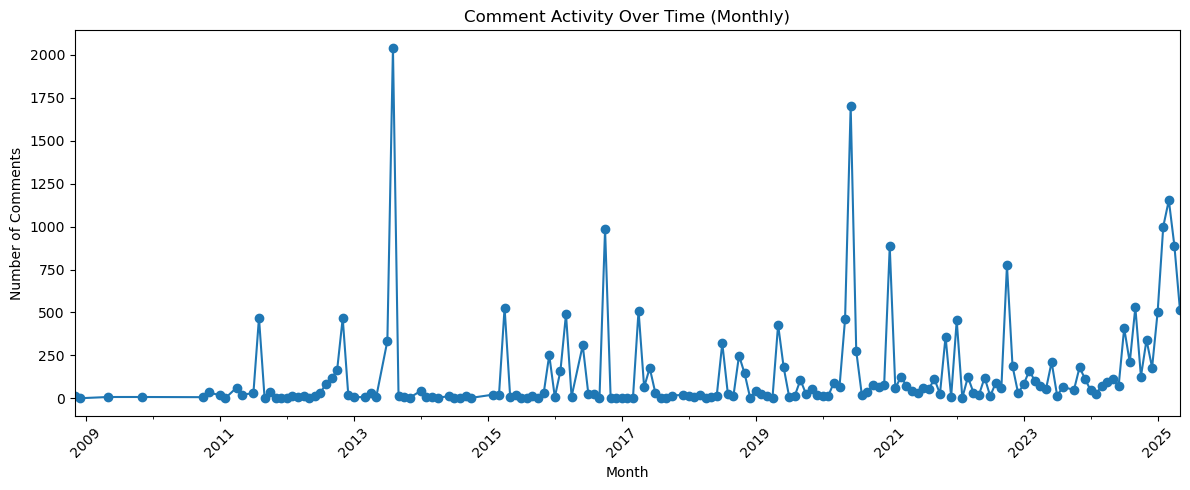

In [16]:
# Plot
plt.figure(figsize=(12, 5))
monthly_counts.plot(kind='line', marker='o')
plt.title("Comment Activity Over Time (Monthly)")
plt.xlabel("Month")
plt.ylabel("Number of Comments")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


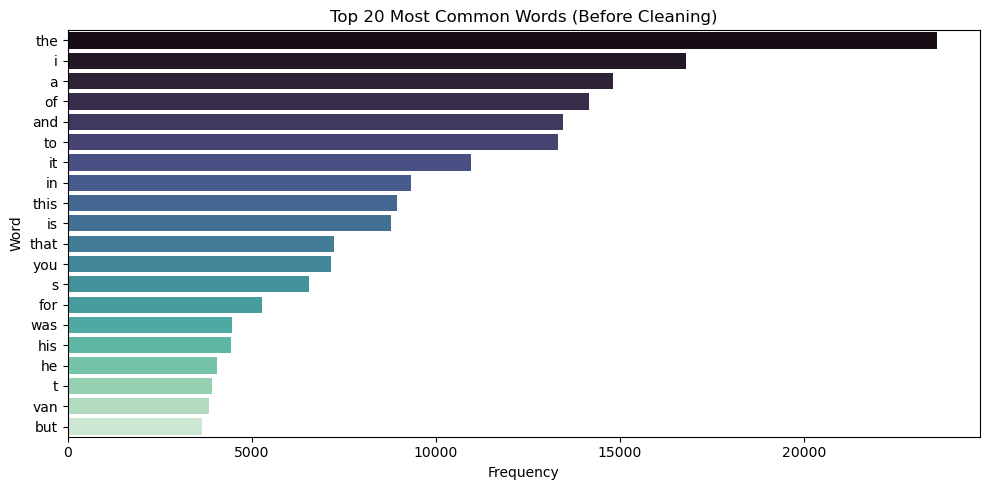

In [19]:
# Step 1: Load the JSON data
with open("reddit_vangogh_final3.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Step 2: Extract all 'text' content
all_text = []
for item in data:
    if 'text' in item and isinstance(item['text'], str):
        all_text.append(item['text'])

# Step 3: Combine and tokenize
raw_text = " ".join(all_text).lower()
tokens = re.findall(r'\b\w+\b', raw_text)

# Step 4: Count top 20 words
common_words = dict(Counter(tokens).most_common(20))

# Step 5: Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=list(common_words.values()), y=list(common_words.keys()), palette="mako")
plt.title("Top 20 Most Common Words (Before Cleaning)")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.tight_layout()
plt.show()

## Preprocessing

In [20]:
nltk.download('stopwords')
nltk.download('wordnet')

# STEP 1: LOAD RAW DATA 
df = pd.read_json("reddit_vangogh_final3.json")  

# STEP 2: REMOVE BOT MESSAGES
bot_keywords = ["bot", "automoderator"]
def is_bot(author):
    author = str(author).lower()
    return any(bot_word in author for bot_word in bot_keywords)

df = df[~df["author"].apply(is_bot)]
print(f"Removed bot messages. Remaining rows: {len(df)}")

# STEP 3: BASIC CLEANING & TYPE CONVERSION
df = df[df['text'].notnull()]
df = df[df['text'].str.strip().str.len() > 0]

df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df['score'] = pd.to_numeric(df['score'], errors='coerce')
df['depth'] = pd.to_numeric(df['depth'], errors='coerce')
df['replies_count'] = df['replies'].apply(lambda x: len(x) if isinstance(x, list) else 0)
df['hashtags'] = df['hashtags'].fillna("None")

df = df[df['timestamp'].notnull()]
df = df[df['score'].notnull() & df['depth'].notnull()]

# STEP 4: SETUP FOR PREPROCESSING
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def preprocess_text(text):
    cleaned = clean_text(text)
    tokens = tokenizer.tokenize(cleaned)
    return [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]

# STEP 5: APPLY TOKENIZATION & CLEANING
df["filtered_tokens"] = df["text"].apply(preprocess_text)
df["word_count"] = df["filtered_tokens"].apply(len)
df["final_cleaned"] = df["filtered_tokens"].apply(lambda x: " ".join(x))

# STEP 6: TOKEN FREQUENCY FILTERING
all_tokens = [word for token_list in df["filtered_tokens"] for word in token_list]
token_counts = Counter(all_tokens)
min_freq = 3
max_doc_freq = 0.5 * len(df)

def filter_tokens(token_list):
    return [word for word in token_list if token_counts[word] >= min_freq and token_counts[word] <= max_doc_freq]

def remove_short_words(tokens, min_len=4):
    return [word for word in tokens if len(word) >= min_len]

df["filtered_tokens"] = df["filtered_tokens"].apply(filter_tokens).apply(remove_short_words)
df["final_cleaned"] = df["filtered_tokens"].apply(lambda x: " ".join(x))

# STEP 7: SELECT FINAL COLUMNS
columns_to_keep = [
    "source", "subreddit", "post_title", "post_text", "post_url", "post_timestamp",
    "comment_id", "parent_id", "timestamp", "depth", "author", "text",
    "score", "replies_count", "hashtags", "filtered_tokens", "word_count", "final_cleaned"
]
df = df[columns_to_keep]

# STEP 8: EXPORT CLEANED DATA (Optional but recommended)
df.to_csv("cleaned_vangogh_comments3.csv", index=False)
print("Final cleaned dataset saved as 'cleaned_vangogh_comments.csv'")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Removed bot messages. Remaining rows: 23372
Final cleaned dataset saved as 'cleaned_vangogh_comments.csv'


In [21]:
# Load the cleaned CSV
df = pd.read_csv("cleaned_vangogh_comments3.csv")

# Print the first 5 rows
print(df.head())

   source subreddit                                         post_title  \
0  reddit       Art  Why is Van Gogh so famous when his art looks a...   
1  reddit       Art  Why is Van Gogh so famous when his art looks a...   
2  reddit       Art  Why is Van Gogh so famous when his art looks a...   
3  reddit       Art  Why is Van Gogh so famous when his art looks a...   
4  reddit       Art  Why is Van Gogh so famous when his art looks a...   

                                           post_text  \
0  I posted this in AskReddit before, but it was ...   
1  I posted this in AskReddit before, but it was ...   
2  I posted this in AskReddit before, but it was ...   
3  I posted this in AskReddit before, but it was ...   
4  I posted this in AskReddit before, but it was ...   

                                            post_url       post_timestamp  \
0  https://www.reddit.com/r/Art/comments/674ffr/w...  2017-04-23T20:13:52   
1  https://www.reddit.com/r/Art/comments/674ffr/w...  2017-04-23

In [22]:
# Create new column: length of cleaned text
df['cleaned_text_length'] = df['final_cleaned'].apply(lambda x: len(str(x)))


## Exploratory Analysis - Cleaned data

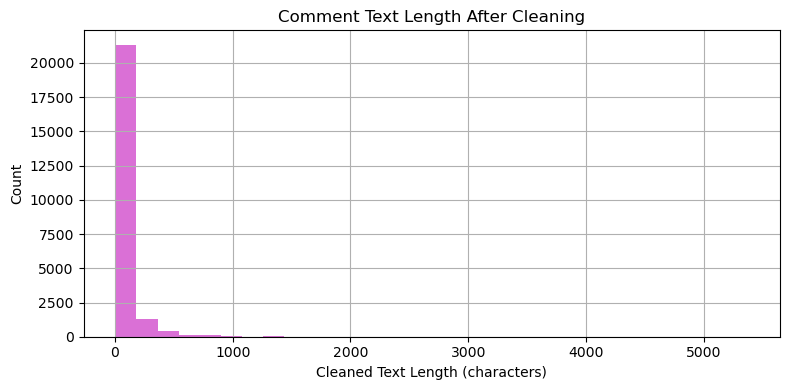

In [23]:
# Plot 1: Cleaned Text Length Distribution
plt.figure(figsize=(8, 4))
df['cleaned_text_length'].hist(bins=30, color='orchid')
plt.title("Comment Text Length After Cleaning")
plt.xlabel("Cleaned Text Length (characters)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

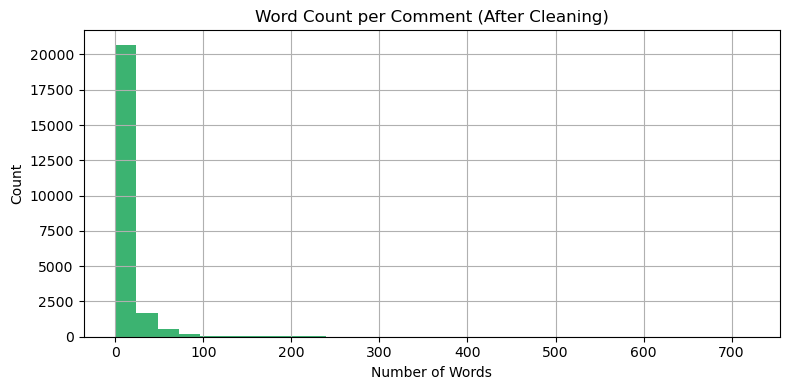

In [24]:
# Plot 2: Word Count Distribution (After Cleaning)
plt.figure(figsize=(8, 4))
df['word_count'].dropna().astype(int).hist(bins=30, color='mediumseagreen')
plt.title("Word Count per Comment (After Cleaning)")
plt.xlabel("Number of Words")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


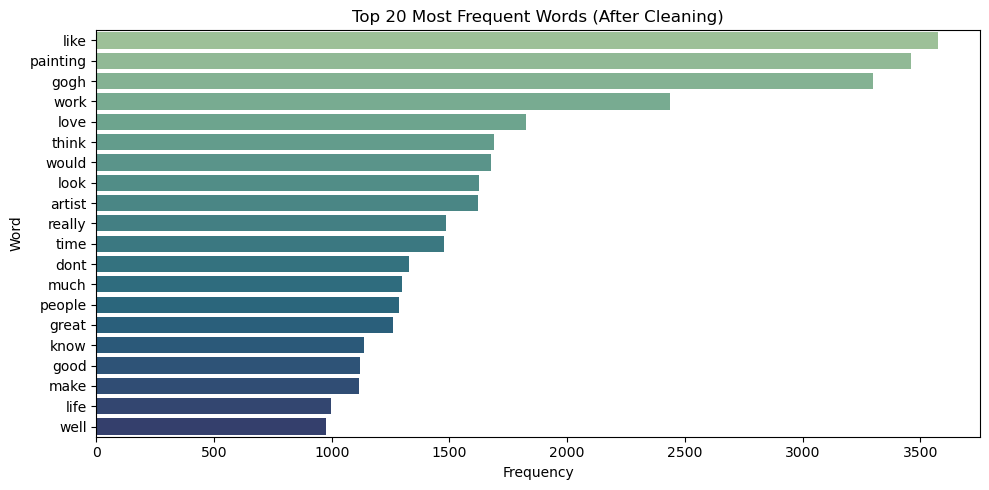

In [25]:
# Step 2: Convert 'filtered_tokens' from string to actual list using ast.literal_eval
df['filtered_tokens'] = df['filtered_tokens'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

#  Step 3: Extract valid words (length > 2, all alphabetic)
all_clean_tokens = [
    word.lower() for tokens in df['filtered_tokens'].dropna()
    for word in tokens
    if isinstance(word, str) and word.isalpha() and len(word) > 2
]

# Step 4: Count word frequencies
word_freq = Counter(all_clean_tokens)
common_words = dict(word_freq.most_common(20))
#  Step 5: Plot the top 20 frequent words
plt.figure(figsize=(10, 5))
sns.barplot(x=list(common_words.values()), y=list(common_words.keys()), palette="crest")
plt.title("Top 20 Most Frequent Words (After Cleaning)")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.tight_layout()
plt.show()

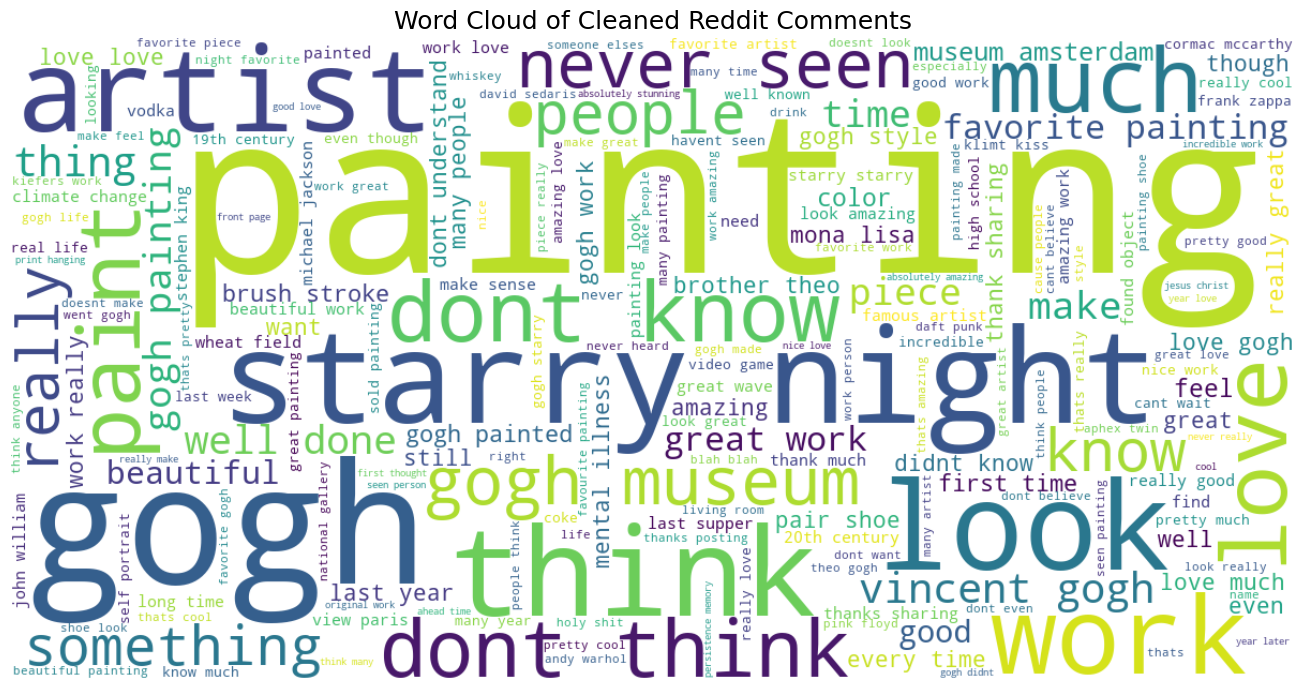

In [26]:
# Step 2: Join all cleaned comments into a single string
text_blob = " ".join(df['final_cleaned'].dropna().astype(str))

# Step 3: Generate and display the word cloud
wordcloud = WordCloud(
    width=1200,
    height=600,
    background_color='white',
    max_words=200,
    colormap='viridis'
).generate(text_blob)
# Step 4: Plot the word cloud
plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Cleaned Reddit Comments", fontsize=18)
plt.tight_layout()
plt.show()

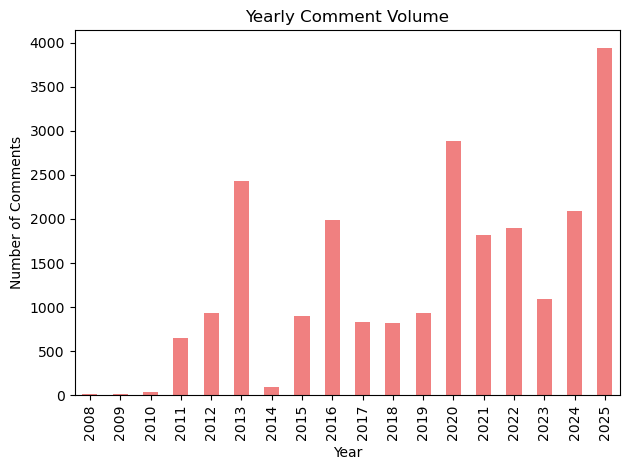

In [27]:
df['year'] = pd.to_datetime(df['timestamp']).dt.year
df['year'].value_counts().sort_index().plot(kind='bar', color='lightcoral')
plt.title("Yearly Comment Volume")
plt.xlabel("Year")
plt.ylabel("Number of Comments")
plt.tight_layout()
plt.show()

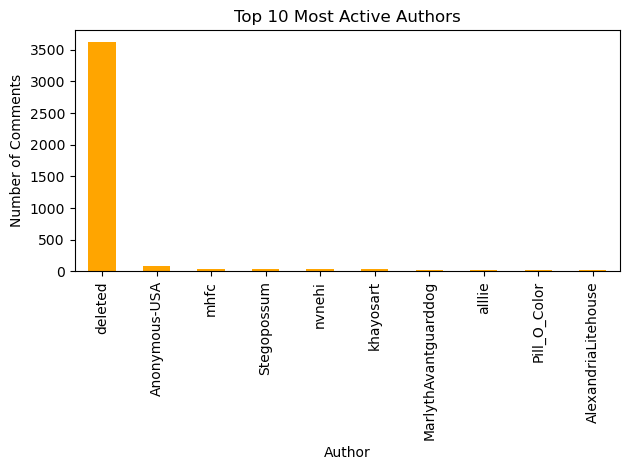

In [28]:
df['author'].value_counts().head(10).plot(kind='bar', color='orange')
plt.title("Top 10 Most Active Authors")
plt.xlabel("Author")
plt.ylabel("Number of Comments")
plt.tight_layout()
plt.show()

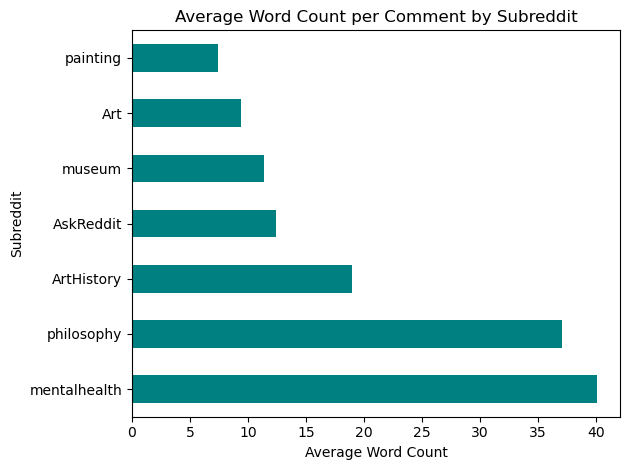

In [29]:
df.groupby('subreddit')['word_count'].mean().sort_values(ascending=False).head(10).plot(kind='barh', color='teal')
plt.title("Average Word Count per Comment by Subreddit")
plt.xlabel("Average Word Count")
plt.ylabel("Subreddit")
plt.tight_layout()
plt.show()

## Graph Modelling

In [164]:
# Load raw JSON data
with open("reddit_vangogh_final3.json", "r", encoding="utf-8") as f:
    raw_data = json.load(f)

# Build edges: reply_author → original_comment_author
edges = []
for entry in raw_data:
    parent_author = entry.get("author", "")
    if not parent_author or parent_author.lower() == "deleted":
        continue
    replies = entry.get("replies", [])
    for reply in replies:
        reply_author = reply.get("author", "")
        if reply_author and reply_author.lower() != "deleted" and reply_author != parent_author:
            edges.append((reply_author, parent_author))

# Create directed graph
G_reply = nx.DiGraph()
G_reply.add_edges_from(edges)

print(f"Graph built: {G_reply.number_of_nodes()} users, {G_reply.number_of_edges()} reply edges")

Graph built: 2810 users, 2189 reply edges


In [165]:
# !pip install python-louvain
import community as community_louvain
import matplotlib.pyplot as plt

# Louvain works on undirected graph
G_undirected = G_reply.to_undirected()
partition = community_louvain.best_partition(G_undirected)
modularity_score = community_louvain.modularity(partition, G_undirected)

# Assign community as node attribute
nx.set_node_attributes(G_reply, partition, "community")

print(f"Modularity Score: {modularity_score:.4f}")


Modularity Score: 0.9891


In [166]:
deg_cent = nx.degree_centrality(G_reply)
bet_cent = nx.betweenness_centrality(G_reply)
pg_rank = nx.pagerank(G_reply)

top_deg = sorted(deg_cent.items(), key=lambda x: x[1], reverse=True)[:5]
top_bet = sorted(bet_cent.items(), key=lambda x: x[1], reverse=True)[:5]
top_pg = sorted(pg_rank.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top by Degree:", top_deg)
print("Top by Betweenness:", top_bet)
print("Top by PageRank:", top_pg)


Top by Degree: [('b214n', 0.011035955856176576), ('Anonymous-USA', 0.008543965824136704), ('allengrutas', 0.006763972944108224), ('WearyFrog', 0.006407974368102528), ('Velius82', 0.006407974368102528)]
Top by Betweenness: [('Anonymous-USA', 2.649704500897096e-05), ('Calico_Dick_Fringe', 1.1917331248053924e-05), ('alllie', 1.1410210769413332e-05), ('cilantroavocado', 1.014240957281185e-05), ('Unlucky-Meringue6187', 9.128168615530665e-06)]
Top by PageRank: [('defy313', 0.003840874334686446), ('A_Fortiori', 0.0034505889643750226), ('JBgreen', 0.0034135692984085977), ('J-G_Wentworth', 0.002845009168840599), ('Anonymous-USA', 0.0028307570657667854)]


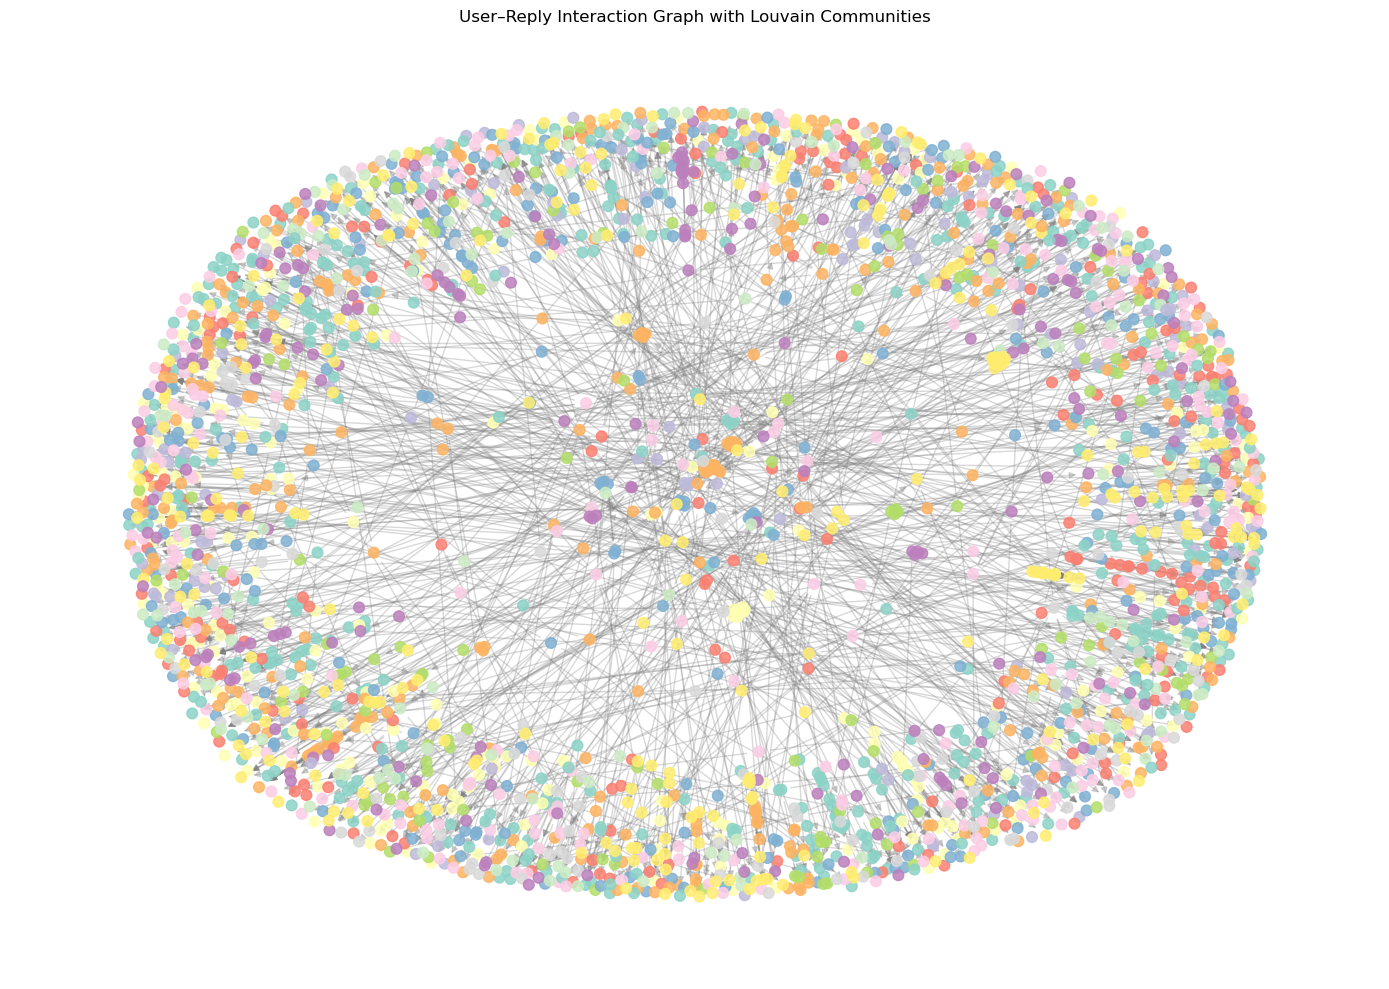

In [153]:
# Position and colors
pos = nx.spring_layout(G_reply, seed=42)
node_colors = [partition.get(node, 0) for node in G_reply.nodes]

plt.figure(figsize=(14, 10))
nx.draw_networkx_nodes(G_reply, pos, node_color=node_colors, cmap=plt.cm.Set3, node_size=60, alpha=0.85)
nx.draw_networkx_edges(G_reply, pos, edge_color="gray", alpha=0.3)
plt.title("User–Reply Interaction Graph with Louvain Communities")
plt.axis("off")
plt.tight_layout()
plt.show()
nx.write_gexf(G_reply, "user_reply_graph.graphml")

In [170]:
# Load the saved JSON file
with open("reddit_vangogh_final3.json", "r", encoding="utf-8") as f:
    all_data = json.load(f)

# Convert it into a DataFrame
df = pd.DataFrame(all_data)

# Display the first 5 rows
print(df.head())


   source subreddit platform_id  \
0  reddit       Art      674ffr   
1  reddit       Art      674ffr   
2  reddit       Art      674ffr   
3  reddit       Art      674ffr   
4  reddit       Art      674ffr   

                                          post_title  \
0  Why is Van Gogh so famous when his art looks a...   
1  Why is Van Gogh so famous when his art looks a...   
2  Why is Van Gogh so famous when his art looks a...   
3  Why is Van Gogh so famous when his art looks a...   
4  Why is Van Gogh so famous when his art looks a...   

                                           post_text  \
0  I posted this in AskReddit before, but it was ...   
1  I posted this in AskReddit before, but it was ...   
2  I posted this in AskReddit before, but it was ...   
3  I posted this in AskReddit before, but it was ...   
4  I posted this in AskReddit before, but it was ...   

                                            post_url       post_timestamp  \
0  https://www.reddit.com/r/Art/commen

In [171]:
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Build graph from 'replies' → parent author
for index, row in df.iterrows():
    parent_author = row.get("author", "")
    replies = row.get("replies", [])

    if not isinstance(replies, list) or parent_author == "[deleted]":
        continue

    for reply in replies:
        reply_author = reply.get("author", "")
        if reply_author and reply_author != "[deleted]" and reply_author != parent_author:
            G.add_node(parent_author, type='user')
            G.add_node(reply_author, type='user')
            G.add_edge(parent_author, reply_author)

# Confirm the graph is built
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())


Number of nodes: 3092
Number of edges: 2772


C:\Users\HP\AppData\Local\Temp\ipykernel_17416\1768438162.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', num_communities)


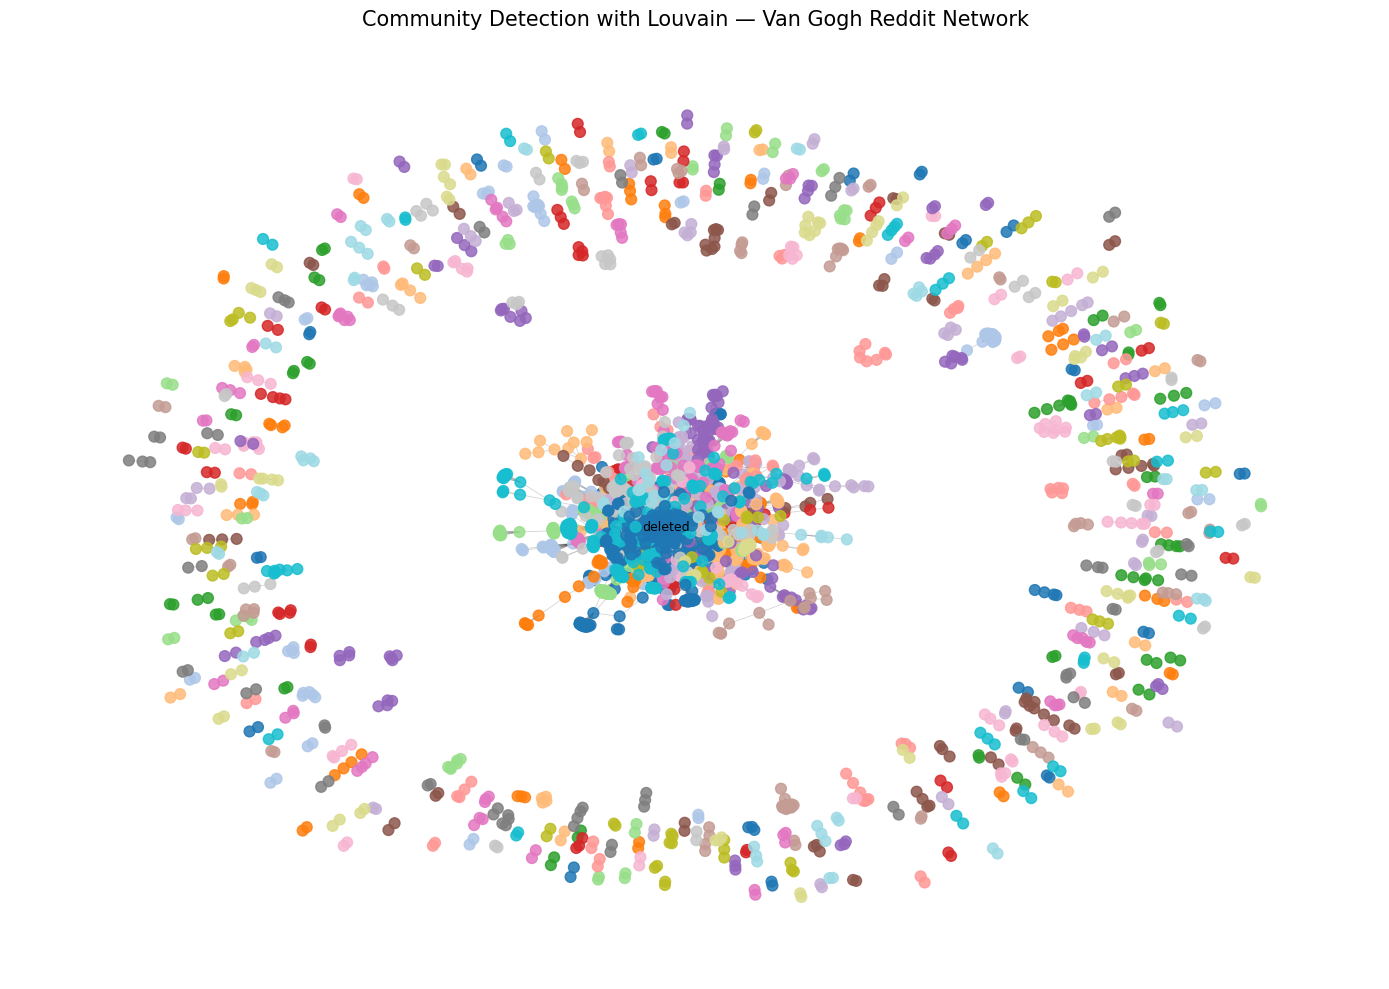

In [172]:
import matplotlib.cm as cm
import networkx as nx

# Step 1: Convert to undirected for Louvain
G_undirected = G.to_undirected()

# Step 2: Run Louvain algorithm
partition = community_louvain.best_partition(G_undirected)

# Step 3: Assign community as node attribute
nx.set_node_attributes(G_undirected, partition, "community")

# Step 4: Visualization
num_communities = len(set(partition.values()))
cmap = cm.get_cmap('tab20', num_communities)
colors = [cmap(partition[n]) for n in G_undirected.nodes()]

# Layout
pos = nx.spring_layout(G_undirected, seed=42)

# Draw the graph
plt.figure(figsize=(14, 10))
nx.draw_networkx_nodes(G_undirected, pos, node_color=colors, node_size=60, alpha=0.85)
nx.draw_networkx_edges(G_undirected, pos, alpha=0.2, width=0.5)

# Label the largest community
largest_comm = max(set(partition.values()), key=list(partition.values()).count)
label_nodes = {
    node: node for node, comm in partition.items()
    if comm == largest_comm and G_undirected.degree(node) > 5
}
nx.draw_networkx_labels(G_undirected, pos, labels=label_nodes, font_size=9)

plt.title("Community Detection with Louvain — Van Gogh Reddit Network", fontsize=15)
plt.axis("off")
plt.tight_layout()
plt.show()
nx.write_gexf(G_reply, "Community Detection with Louvain — Van Gogh Reddit Network.graphml")

C:\Users\HP\AppData\Local\Temp\ipykernel_17416\2564158337.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', num_communities)
C:\Users\HP\AppData\Local\Temp\ipykernel_17416\2564158337.py:39: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  plt.tight_layout()


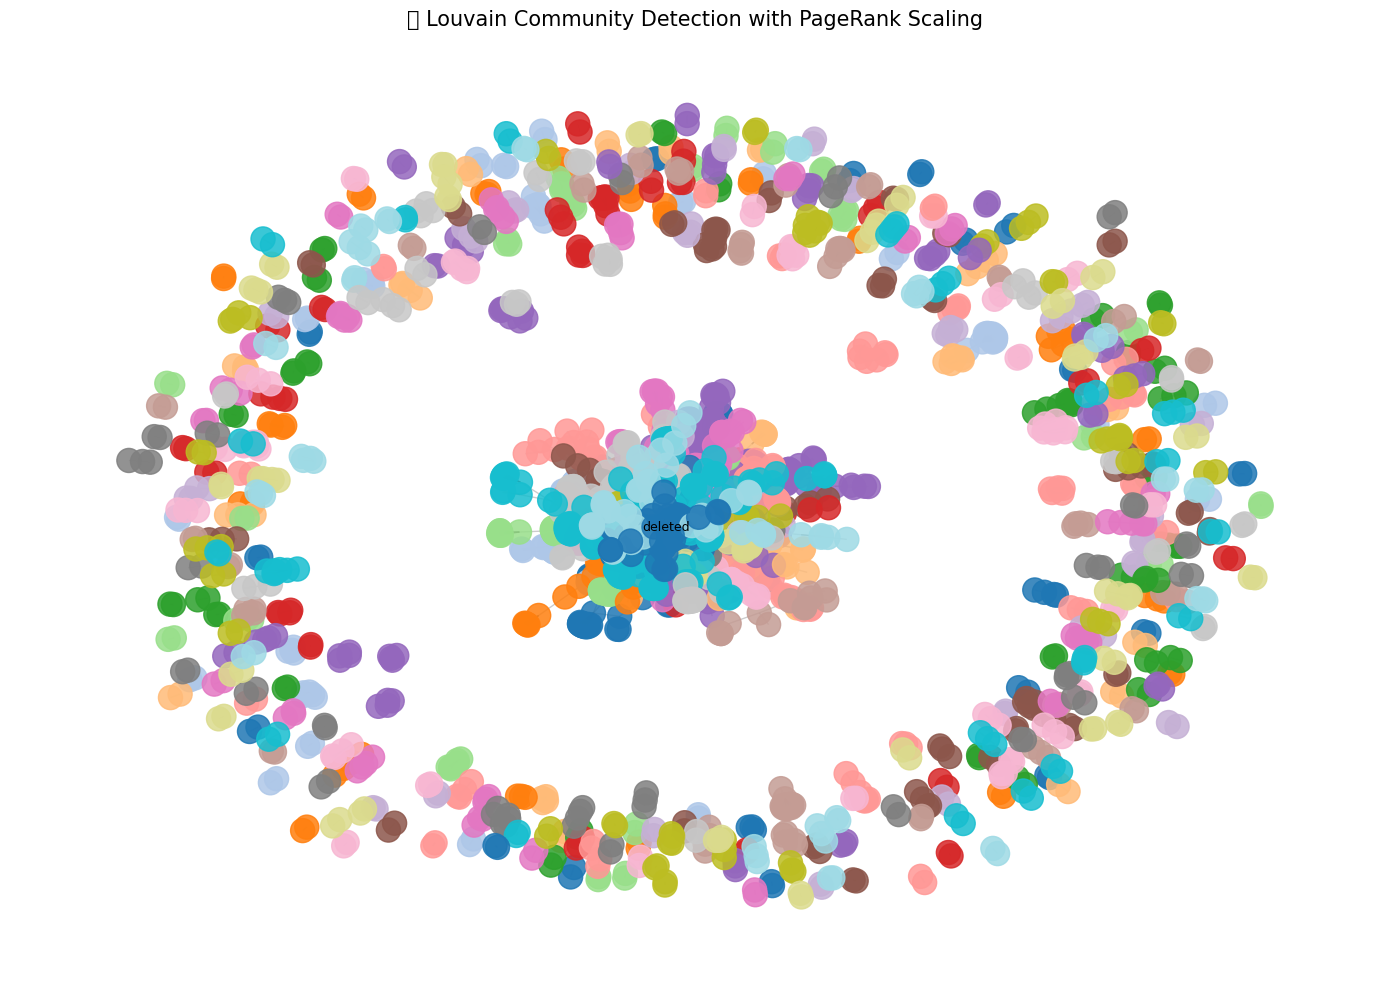

In [102]:
# Remove '[deleted]' if present
if '[deleted]' in G:
    G.remove_node('[deleted]')

# Convert to undirected for Louvain
G_undirected = G.to_undirected()

# Louvain detection
partition = community_louvain.best_partition(G_undirected)
nx.set_node_attributes(G_undirected, partition, 'community')

# PageRank for node size
pagerank = nx.pagerank(G_undirected)
node_sizes = [300 + 2000 * pagerank[n] for n in G_undirected.nodes()]

# Color by community
num_communities = len(set(partition.values()))
cmap = cm.get_cmap('tab20', num_communities)
colors = [cmap(partition[n]) for n in G_undirected.nodes()]

# Layout
pos = nx.spring_layout(G_undirected, seed=42)

# Draw
plt.figure(figsize=(14, 10))
nx.draw_networkx_nodes(G_undirected, pos, node_color=colors, node_size=node_sizes, alpha=0.85)
nx.draw_networkx_edges(G_undirected, pos, alpha=0.2)

# Label top users from the largest community
largest_comm = max(set(partition.values()), key=list(partition.values()).count)
label_nodes = {
    node: node for node, comm in partition.items()
    if comm == largest_comm and G_undirected.degree(node) > 8
}
nx.draw_networkx_labels(G_undirected, pos, labels=label_nodes, font_size=9)

plt.title("🧠 Louvain Community Detection with PageRank Scaling", fontsize=15)
plt.axis("off")
plt.tight_layout()
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_17416\131729659.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_trend = community_df.set_index('timestamp').resample('M').size()
C:\Users\HP\AppData\Local\Temp\ipykernel_17416\131729659.py:22: UserWarning: Glyph 128467 (\N{SPIRAL CALENDAR PAD}) missing from current font.
  plt.tight_layout()
C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128467 (\N{SPIRAL CALENDAR PAD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128467 (\N{SPIRAL CALENDAR PAD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


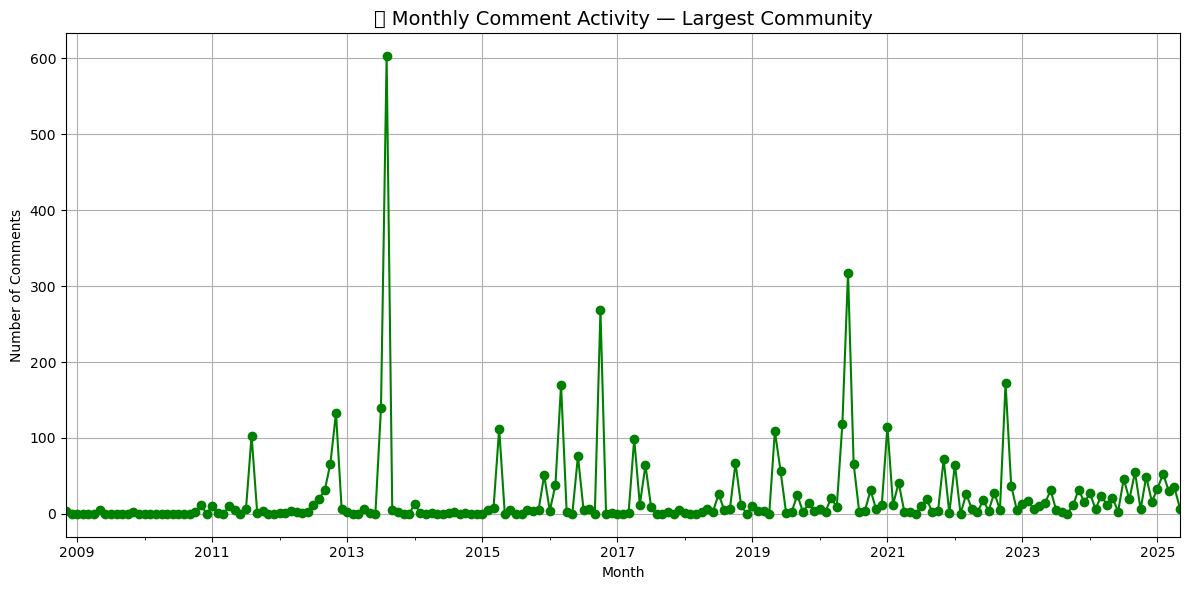

In [105]:
# Ensure timestamp is in datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.dropna(subset=['timestamp'])

# Step 1: Filter users in the largest community
largest_comm = max(set(partition.values()), key=list(partition.values()).count)
community_users = [node for node, comm in partition.items() if comm == largest_comm]

# Step 2: Filter df for rows where author is in that community
community_df = df[df['author'].isin(community_users)]

# Step 3: Resample by month
monthly_trend = community_df.set_index('timestamp').resample('M').size()

# Step 4: Plot
plt.figure(figsize=(12, 6))
monthly_trend.plot(kind='line', color='green', marker='o')
plt.title("🗓️ Monthly Comment Activity — Largest Community", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Number of Comments")
plt.grid(True)
plt.tight_layout()
plt.show()